# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5 Phase 2


---
__Name:__  Nicholas Vogler  
__Class:__ MIDS w261 Spring 2018 Section 2   
__Email:__  nvogler@Berkeley.edu       
__StudentId__  3032599753       
__Week:__   5.5  

__NOTE:__ please replace `1234567` with your student id above      
__Due Time:__ HW is due the Thursday of the following week by 8AM (West coast time).

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as Altiscale's PaaS or on AWS) and is due Thursday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the Altiscale cluster and will be due Thursday of the following week by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. 

# Datasets

For Phase 2 you will first use the small datasets from phase 1 to systems test your code in the cloud. Then you will test your code on 1 file and then 20 files before running the full (191 file) Google n-gram dataset.

__Small data for systems tests__

In [3]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


In [2]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


__Paths to Main data in HDFS on Altiscale__

In [1]:
TEST_1 = "/user/winegarj/data/1_test"
TEST_20 = "/user/winegarj/data/20_test"
FULL_DATA = "/user/winegarj/data/full"

In [ ]:
!hdfs dfs -ls "/user/nvogler/"

# Set - Up for Phase 2
Before you can run your simlarity analysis on the full Google n-gram dataset you should confirm that the code your wrote in Phase 1 works on the cloud. In the space below, copy the code for your three jobs from Phase 1 (`buildStripes.py`, `invertedIndex.py`, `similarity.py`) and rerun your  atlas-boon systems tests on Altiscale (i.e. ** the cloud**). NOTE: _you may end up modifying this code when you get to 5.7, that's fine._

### `buildStripes.py`

In [ ]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRbuildStripes(MRJob):
  
    #START SUDENT CODE531_STRIPES
    # Input Format
    # (ngram) \t (count) \t (pages_count) \t (books_count)
    def mapper(self, _, line):
        # Split line into data segments
        ngrams, count, p_count, b_count = line.strip().lower().split('\t')
        # Transform ngrams string to list of words in the ngram
        ngram_list = ngrams.strip().split()
        
        for term in ngram_list:
            yield term, {pair: int(count) for pair in ngram_list if pair != term}
            
    #  \/ - Output Format 
    # (term) {(pair_1): (count), (pair_n): (count)}
    #  /\ - Input Format
    
    def reducer(self, key, values):
        ngram_counts = {}
        
        for value in values:
            for sub_key in value.keys():
                if sub_key not in ngram_counts.keys():
                    ngram_counts[sub_key] = 0
                ngram_counts[sub_key] += value[sub_key]
        
        yield key, ngram_counts
        
    #END SUDENT CODE531_STRIPES

if __name__ == '__main__':
  MRbuildStripes.run()

In [ ]:
!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1
!cat systems_test_stripes_1 

In [ ]:
!python buildStripes.py -r local atlas-boon-systems-test.txt > systems_test_stripes_2
!cat systems_test_stripes_2 

In [ ]:
with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3 

### `invertedIndex.py`

In [ ]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex(MRJob):
    
    #START SUDENT CODE531_INV_INDEX
    # Input
    # "atlas"	{"dipped":15,"boon":50}
    def mapper(self, _, line):
        key, values = line.strip().split("\t")
        values = json.loads(values)
        count = len(values)
        for term in values:
            yield (term, key.strip("\"") + ',' + str(count))
    
    def reducer(self, key, values):
        index = []
        for value in values:
            word, count = value.split(',')
            index.append((word, count))
        yield key, index
    #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

In [ ]:
!python invertedIndex.py -r local systems_test_stripes_1 > systems_test_index_1
!cat systems_test_index_1

In [ ]:
!python invertedIndex.py -r local systems_test_stripes_2 > systems_test_index_2
!cat systems_test_index_2

In [ ]:
!python invertedIndex.py -r local systems_test_stripes_3 > systems_test_index_3
!cat systems_test_index_3

### `similarity.py`

In [ ]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.protocol import JSONProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
    
    #START STUDENT CODE531_SIMILARITY
    def mapper_one(self, _, line):
        # Process line -> key, values
        key, values = line.strip().split('\t')
        
        # Decode JSON
        values = json.loads(values)
        key = json.loads(key)
        
        # Calc pairs, add singles where necessary
        if len(values) > 1:
            pairs = itertools.combinations(sorted(list(values)), 2)
            for pair in pairs:
                yield pair[0][0] + ':' + pair[1][0], 1
        else:
            yield values[0][0] + ':_', 1
        
        for value in values:
            yield value[0], 1
    
    # Combiner/reducer one: sum and pass on
    def combiner_one(self, key, values):
        val_sum = 0
        for val in values:
            val_sum += val
        yield key, val_sum

    def reducer_one(self, key, values):
        val_sum = 0
        for val in values:
            val_sum += val
        yield key, val_sum
    
    # Stage two, need to tell pair components to share cardinality
    def mapper_two(self, key, values):
        # Cardinality key
        if len(key.split(':')) == 1:
            # Pass through
            yield key, values
        # Pair key
        else:
            # Tell right pair to share with left pair (if not null)
            l_pair, r_pair = key.split(':')
            if r_pair != "_":
                yield r_pair, l_pair
            # Tell left pair they are in a pair with overlap X
            yield l_pair, str(key) + ';' + str(values)
            
    def reducer_two(self, key, values):
        # Check values for cardinality/pairs/request to share
        cardinality = 0
        shares = []
        
        for value in values:
            # Cardinality
            if type(value) == int:
                cardinality = value
                yield key, value
            else:
                split_val = value.split(':')
                # Pair
                if len(split_val) > 1:
                    yield key, value
                # Share
                elif len(split_val) == 1:
                    shares.append(value)
        
        # Share cardinality
        for share in shares:
            yield share, str(key) + '.' + str(cardinality)

    def reducer_three(self, key, values):
        # Process values
        l_card = 0
        pairs = {}
        p_card = {}
        
        for value in values:
            # Cardinality
            if type(value) == int:
                l_card = value
            else:
                split_val = value.split(':')
                # Pair
                if len(split_val) > 1:
                    pair, count = value.split(';')
                    pairs[pair] = count
                # Share
                elif len(split_val) == 1:
                    pair, card = value.split('.')
                    p_card[pair] = card
                    
        # Iterate pairs and make calculations
        for pair in pairs.keys():
            l_pair, r_pair = pair.split(':')
            if r_pair == "_": continue # _ != pair
            # Pull values for calcs
            r_card = float(p_card[r_pair])  
            union = float(pairs[pair])
            
            # Results
            result = []
            # Dice
            dice = round(2*union/(l_card + r_card), 6)
            # Overlap
            overlap = round(union/min(l_card, r_card), 6)
            # Jaccard
            jaccard = round(union / (l_card + r_card - union), 6)
            # Cosine
            cosine = round(union/(l_card**.5 * r_card**.5), 6)
            # Pair
            # Average
            average = round(((jaccard+cosine+dice+overlap) / 4), 6)
            result.append(pair.replace(':', ' - '))
            result.append(cosine) 
            result.append(jaccard)  
            result.append(overlap) 
            result.append(dice)
                       
            yield average, result
            
    def steps(self):
        return [
            MRStep(mapper=self.mapper_one,
                   combiner=self.combiner_one,
                   reducer=self.reducer_one),
            MRStep(mapper=self.mapper_two,
                  reducer=self.reducer_two),
            MRStep(reducer=self.reducer_three)
            ]
  
    #END SUDENT CODE531_SIMILARITY

if __name__ == '__main__':
    MRsimilarity.run()

In [ ]:
!hdfs dfs -rm -R "/user/nvogler/sys_test_sim_1"
!python similarity.py -r hadoop systems_test_index_1 --output-dir="/user/nvogler/sys_test_sim_1" --no-output
!hdfs dfs -cat "/user/nvogler/sys_test_sim_1/*"

In [ ]:
!hdfs dfs -rm -R "/user/nvogler/sys_test_sim_2"
!python similarity.py -r hadoop systems_test_index_2 --output-dir="/user/nvogler/sys_test_sim_2" --no-output
!hdfs dfs -cat "/user/nvogler/sys_test_sim_2/*"

In [ ]:
!hdfs dfs -rm -R "/user/nvogler/sys_test_sim_3"
!python similarity.py -r hadoop systems_test_index_3 --output-dir="/user/nvogler/sys_test_sim_3" --no-output
!hdfs dfs -cat "/user/nvogler/sys_test_sim_3/*"

#### 10-line systems test

# HW5.6 -Google n-grams EDA

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.6.1 - A. Longest 5-gram (number of characters)

In [104]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):

    # START STUDENT CODE 5.6.1.A
    def mapper(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        yield len(ngram), ngram
            
    def reducer(self, key, values):
        for value in values:
            yield key, value

    # END STUDENT CODE 5.6.1.A
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


__On test data set:__

In [105]:
OUTPUT_PATH = "/user/nvogler/5_6_1A"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python longest5gram.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --jobconf stream.num.map.output.key.fields=1 \
    --jobconf mapreduce.partition.keypartitioner.options=-k1,1 \
    --jobconf mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    --jobconf mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test1_5_6_1a

18/03/07 02:40:48 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_6_1A' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.nvogler.20180307.024049.757038
Copying local files to hdfs:///user/nvogler/tmp/mrjob/longest5gram.nvogler.20180307.024049.757038/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3336294254205105114.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1

In [110]:
!head -n 1 test1_5_6_1a

58	"hydroxytryptamine stimulates inositol phosphate production"
58	"interpersonal communication interpersonal communication is"
57	"der verfassungsgebenden deutschen nationalversammlung und"
57	"guidelines for clinical intracardiac electrophysiological"
55	"oligonucleotide arrays using semiconductor photoresists"
55	"differential reinforcement of successive approximations"
55	"prevention of experimental autoimmune encephalomyelitis"
55	"diabetic glomerulopathy by pharmacological amelioration"
54	"pulmonary dysfunction following traumatic quadriplegia"
54	"east hertfordshire archaeological society transactions"


__ On the 20 files dataset: __

In [256]:
OUTPUT_PATH = "/user/nvogler/5_6_1A_20"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python longest5gram.py \
    -r hadoop "hdfs:///user/winegarj/data/20_test" \
    --jobconf stream.num.map.output.key.fields=1 \
    --jobconf mapreduce.partition.keypartitioner.options=-k1,1 \
    --jobconf mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    --jobconf mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test1_5_6_1a_20

18/03/07 06:01:45 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_6_1A_20' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.nvogler.20180307.060146.700051
Copying local files to hdfs:///user/nvogler/tmp/mrjob/longest5gram.nvogler.20180307.060146.700051/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5041791751256093922.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws

In [257]:
!head -n 1 test1_5_6_1a_20

83	"engineeringgraphic design applied sciencespsychology interiordesignbiologychemistry"


__On full data set:__

In [ ]:
OUTPUT_PATH = "/user/nvogler/5_6_1A_full"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python longest5gram.py \
    -r hadoop "hdfs:///user/winegarj/data/full" \
    --jobconf stream.num.map.output.key.fields=1 \
    --jobconf mapreduce.partition.keypartitioner.options=-k1,1 \
    --jobconf mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    --jobconf mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test1_5_6_1a_full

In [ ]:
!head test1_5_6_1a_full

### Longest 5grams MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

__Step 1:__  

    RUNNING for 107.0s ~= 2 minutes  
    Reduce tasks = 16 
    
__Step 2:__   

    RUNNING for 108.8s ~= 2 minutes
    Reduce tasks = 1  

### HW5.6.1 - B. Top 10 most frequent words 

In [267]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):

    MRJob.SORT_VALUES = True
    
    # START STUDENT CODE 5.6.1.B
    def mapper(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        
        for gram in ngram.split(' '):
            yield gram, int(count)
    
    def combiner(self, key, values):
        yield key, sum(values)
    
    def reducer(self, key, values):
        yield key, sum(values)
    
    def reducer_two_init(self):
        self.count = 0
        
    def reducer_two(self, key, values):
        if self.count < 10:
            self.count += 1
            for value in values:
                yield key, value
        
    def steps(self):
        JOBCONF_STEP_TWO = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k2,2nr k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer),
            MRStep(reducer_init=self.reducer_two_init,
                    reducer=self.reducer_two,
                   jobconf=JOBCONF_STEP_TWO)
            ]

    # END STUDENT CODE 5.6.1.B
    
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords.py


__On the test data set:__

In [199]:
OUTPUT_PATH = "/user/nvogler/5_6_1B"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python mostFrequentWords.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test1_5_6_1B

rm: `/user/nvogler/5_6_1B': No such file or directory
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.nvogler.20180307.043420.260710
Copying local files to hdfs:///user/nvogler/tmp/mrjob/mostFrequentWords.nvogler.20180307.043420.260710/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5076214684237043256.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-i

In [202]:
!cat test1_5_6_1B

"the"	27691943
"of"	18590950
"to"	11601757
"in"	7470912
"a"	6926743
"and"	6150529
"that"	4077421
"is"	4074864
"be"	3720812


__ On the 20 files dataset: __

In [268]:
OUTPUT_PATH = "/user/nvogler/5_6_1B"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python mostFrequentWords.py \
    -r hadoop "hdfs:///user/winegarj/data/20_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test20_5_6_1B

18/03/07 06:30:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_6_1B' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.nvogler.20180307.063027.323623
Copying local files to hdfs:///user/nvogler/tmp/mrjob/mostFrequentWords.nvogler.20180307.063027.323623/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5181934268826665956.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:

Removing temp directory /tmp/mostFrequentWords.nvogler.20180307.063027.323623...


In [266]:
!cat test20_5_6_1B

"the"	558791097
"of"	374964374
"to"	222326516
"in"	144210167
"a"	136711702
"and"	115463203
"that"	80674504
"is"	79028900
"be"	68741033
"as"	49852316
"it"	48507617


__On the full data set:__

### Most frequent words MR stats
    
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__   

    RUNNING for 590.7s ~= 10 minutes   
    Launched map tasks=191  
    Launched reduce tasks=57   

__Step 2:__  

    RUNNING for 76.6s   
    Launched map tasks=110
    Launched reduce tasks=16  


### HW5.6.1 - C. 20 Most/Least densely appearing words 

In [231]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    MRJob.SORT_VALUES = True
    
    # START STUDENT CODE 5.6.1.C
    def mapper(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        
        for gram in ngram.split(' '):
            yield gram, count + ',' + p_count
    
    def combiner(self, key, values):
        count = 0
        p_count = 0
        for value in values:
            count += int(value.split(',')[0])
            p_count += int(value.split(',')[1])
        yield key, str(count) + ',' + str(p_count)
    
    def reducer(self, key, values):
        count = 0
        p_count = 0
        for value in values:
            count += int(value.split(',')[0])
            p_count += int(value.split(',')[1])
        
        yield key, np.round(count / p_count, 6)
    
    def reducer_two_init(self):
        self.count = 0
        
    def reducer_two(self, key, values):
        if self.count < 20:
            self.count += 1
            for value in values:
                yield key, value
    
    def steps(self):
        JOBCONF_STEP_TWO = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k2,2nr k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer),
            MRStep(reducer_init=self.reducer_two_init,
                    reducer=self.reducer_two,
                   jobconf=JOBCONF_STEP_TWO)
            ]
    # END STUDENT CODE 5.6.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


__On the test data set:__

In [232]:
OUTPUT_PATH = "/user/nvogler/5_6_1C"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python mostLeastDenseWords.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test1_5_6_1C

rm: `/user/nvogler/5_6_1C': No such file or directory
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.nvogler.20180307.053717.331301
Copying local files to hdfs:///user/nvogler/tmp/mrjob/mostLeastDenseWords.nvogler.20180307.053717.331301/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1595962256626015557.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://

In [233]:
!cat test1_5_6_1C

"lak"	3.072289
"operand"	2.353448
"bust"	2.349398
"houseless"	2.274892
"gynecological"	2.248154
"denatured"	2.186441
"expiration"	2.156851
"phe"	2.040816
"kiowa"	2.0
"apiece"	1.960784
"unreachable"	1.943396
"theres"	1.923077
"rumanian"	1.904321
"traitorously"	1.892857
"pilage"	1.833333
"dock"	1.802817
"aristocrat"	1.790698
"pathology"	1.763251
"meanly"	1.72973
"mi"	1.679487


__ On the 20 files dataset: __

In [235]:
OUTPUT_PATH = "/user/nvogler/5_6_1C"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python mostLeastDenseWords.py \
    -r hadoop "hdfs:///user/winegarj/data/20_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > test20_5_6_1C

18/03/07 05:39:57 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_6_1C' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.nvogler.20180307.053958.440845
Copying local files to hdfs:///user/nvogler/tmp/mrjob/mostLeastDenseWords.nvogler.20180307.053958.440845/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob910652307247973054.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.c

Removing temp directory /tmp/mostLeastDenseWords.nvogler.20180307.053958.440845...


In [236]:
!cat test20_5_6_1C

"nn"	6.606897
"llll"	4.511628
"vocht"	3.890215
"pfeffermann"	3.576923
"madarassy"	3.576923
"pogue"	3.406627
"lak"	3.072289
"bl"	3.01928
"nonmorular"	2.81982
"nonsquamous"	2.81982
"surg"	2.740959
"pathol"	2.684245
"teodoro"	2.660377
"neophytos"	2.660377
"edelby"	2.660377
"jimenez"	2.660377
"noncontiguous"	2.625
"med"	2.599037
"irc"	2.560127
"pryntinge"	2.406393


__On the full data set:__

### Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    RUNNING for 649.2s  ~= 10 minutes      
    Launched map tasks=190   
    Launched reduce tasks=57     

__Step 2:__  

    RUNNING for 74.4s  ~= 1 minute    
    Launched map tasks=110   
    Launched reduce tasks=20   

### HW5.6.1 - D. Distribution of 5-gram sizes (character length)

In [247]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    
    MRJob.SORT_VALUES = True
    # Distribution of 5-gram sizes (character length). E.g., count (using the count field)
    #  up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

    # START STUDENT CODE 5.6.1.D
    def mapper(self, _, line):
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        yield len(ngram), int(count)
    
    def combiner(self, key, values):
        yield key, sum(values)
        
    def reducer(self, key, values):
        yield key, sum(values)
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer,
                jobconf=JOBCONF_STEP)
            ]   
    # END STUDENT CODE 5.6.1.D
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


__On the test data set:__

In [253]:
OUTPUT_PATH = "5.6distributions/"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python distribution.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > {OUTPUT_PATH}

18/03/07 05:58:20 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5.6distributions' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.nvogler.20180307.055821.759704
Copying local files to hdfs:///user/nvogler/tmp/mrjob/distribution.nvogler.20180307.055821.759704/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6034617060510849141.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:

__ On the 20 files dataset: __

In [260]:
OUTPUT_PATH = "5.6distributions/"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python distribution.py \
    -r hadoop "hdfs:///user/winegarj/data/20_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > {OUTPUT_PATH}20_test_561D

18/03/07 06:09:07 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5.6distributions' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.nvogler.20180307.060908.261546
Copying local files to hdfs:///user/nvogler/tmp/mrjob/distribution.nvogler.20180307.060908.261546/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2308378766844551805.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:

__On the full data set:__

### Distribution MRJob stats

__Step 1:__ 

    RUNNING for 157.8s ~= 2.6 minutes  
    Launched map tasks=191  
    Launched reduce tasks=16   
    
__Step 2:__  

    RUNNING for 115.0s ~= 2 minutes   
    Launched map tasks=139
	Launched reduce tasks=1  

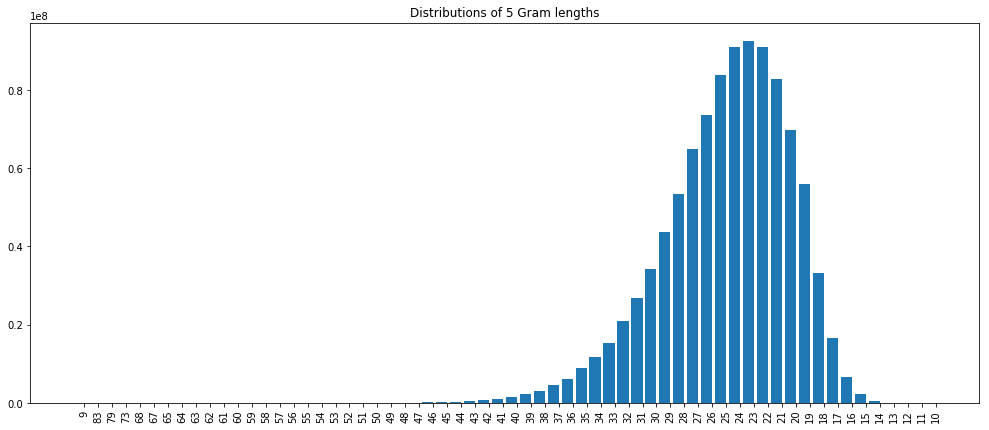

In [261]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("5.6distributions/20_test_561D").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

### HW5.6.2 - OPTIONAL: log-log plots (PHASE 2)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

# HW5.7 - Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3-5 plus some preprocessing)   

For the remainder of this assignment please feel free to eliminate stop words from your analysis (see stopWords in the cell below)

__A large subset of the Google n-grams dataset as was described above__

For each HW 5.6 - 5.7.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.


For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

In [17]:
%%writefile top10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

STOP_WORDS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 's', 't', 'can', 'will', 'just', 
              'don', 'should', 'now']

class top10k(MRJob):

    MRJob.SORT_VALUES = True
    regex = re.compile('[^a-zA-Z]')
    
    def mapper_init(self):
        self.words = {}
        
    def mapper(self, _, line):        
        ngram, count, p_count, b_count = line.strip().lower().split('\t')
        
        for gram in ngram.split(' '):
            trim_gram = self.regex.sub('', gram) 
            if trim_gram not in STOP_WORDS:
                if trim_gram in self.words.keys():
                    self.words[trim_gram] += int(count)
                else:
                    self.words[trim_gram] = int(count)
    
    def mapper_final(self):
        for word in self.words.keys():
            yield word, self.words[word]
            
    def combiner(self, key, values):
        yield key, sum(values)
    
    def reducer(self, key, values):
        yield key, sum(values)
    
    def reducer_two_init(self):
        self.count = 0
        
    def reducer_two(self, key, values):
        if self.count < 10000:
            self.count += 1
            for value in values:
                yield key, value
        
    def steps(self):
        JOBCONF_STEP_TWO = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k2,2nr k1,1',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final,
                   combiner=self.combiner,
                   reducer=self.reducer),
            MRStep(reducer_init=self.reducer_two_init,
                    reducer=self.reducer_two,
                   jobconf=JOBCONF_STEP_TWO)
            ]
    
if __name__ == '__main__':
    top10k.run()

Overwriting top10k.py


In [86]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re
import mrjob
import csv
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import os 

class MRbuildStripes(MRJob):
    
    regex = re.compile('[^a-zA-Z ]')
    
    def mapper_init(self):
        self.top10k = []
        self.top9th = []
        with open('top10k', 'r') as tsvin:
            tsvin = csv.reader(tsvin, delimiter='\t')
            count = 0
            for row in tsvin:
                self.top10k.append(row[0])
                if count > 9000:
                    self.top9th.append(row[0])
                else:
                    count += 1
        
    # Input Format
    # (ngram) \t (count) \t (pages_count) \t (books_count)
    def mapper(self, _, line):
        ngrams, count, p_count, b_count = line.strip().lower().split('\t')
        ngram_list = self.regex.sub('', ngrams.strip()).split()
        
        for term in ngram_list:
            if term in self.top10k:
                output = {pair: int(count) for pair in ngram_list if pair in self.top9th and pair != term}
                if len(output) > 0:
                    yield term, output
            
    #  \/ - Output Format 
    # (term) {(pair_1): (count), (pair_n): (count)}
    #  /\ - Input Format
    def combiner(self, key, values):
        ngram_counts = {}
        
        for value in values:
            for sub_key in value.keys():
                if sub_key not in ngram_counts.keys():
                    ngram_counts[sub_key] = 0
                ngram_counts[sub_key] += value[sub_key]
        
        yield key, ngram_counts
        
    def reducer(self, key, values):
        ngram_counts = {}
        
        for value in values:
            for sub_key in value.keys():
                if sub_key not in ngram_counts.keys():
                    ngram_counts[sub_key] = 0
                ngram_counts[sub_key] += value[sub_key]
        
        yield key, ngram_counts
    
    def steps(self):
        return [
                MRStep(mapper_init=self.mapper_init,
                    mapper=self.mapper,
                    combiner=self.combiner,
                    reducer=self.reducer)
        ]

if __name__ == '__main__':
  MRbuildStripes.run()

Overwriting buildStripes.py


In [56]:
!python buildStripes.py -r local --file "top10k" googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1
!cat systems_test_stripes_1 

Using configs in /home/nvogler/.mrjob.conf
Creating temp directory /tmp/buildStripes.nvogler.20180307.203018.995293
Running step 1 of 1...
Streaming final output from /tmp/buildStripes.nvogler.20180307.203018.995293/output...
Removing temp directory /tmp/buildStripes.nvogler.20180307.203018.995293...


In [59]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex(MRJob):

    # Input
    # "atlas"	{"dipped":15,"boon":50}
    def mapper(self, _, line):
        key, values = line.strip().split("\t")
        values = json.loads(values)
        count = len(values)
        for term in values:
            yield (term, key.strip("\"") + ',' + str(count))
    
    def reducer(self, key, values):
        index = []
        for value in values:
            word, count = value.split(',')
            index.append((word, count))
        yield key, index
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Overwriting invertedIndex.py


In [143]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.protocol import JSONProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
    
    MRJob.SORT_VALUES = True
    
    def mapper_one(self, _, line):
        # Process line -> key, values
        key, values = line.strip().split('\t')
        
        # Decode JSON
        values = json.loads(values)
        key = json.loads(key)
        
        # Calc pairs
        if len(values) > 1:
            pairs = itertools.combinations(sorted(list(values)), 2)
            for pair in pairs:
                yield pair[0][0] + ':' + pair[1][0], 1
        else:
            yield values[0][0] + ':_', 1
        
        for value in values:
            yield value[0], 1
    
    # Combiner/reducer one: sum and pass on
    def combiner_one(self, key, values):
        val_sum = 0
        for val in values:
            val_sum += val
        yield key, val_sum

    def reducer_one(self, key, values):
        val_sum = 0
        for val in values:
            val_sum += val
        yield key, val_sum
    
    # Stage two, need to tell pair components to share cardinality
    def mapper_two(self, key, values):
        # Cardinality key
        if len(key.split(':')) == 1:
            # Pass through
            yield key, values
        # Pair key
        else:
            # Tell right pair to share with left pair (if not null)
            l_pair, r_pair = key.split(':')
            if r_pair != "_":
                yield r_pair, l_pair
            # Tell left pair they are in a pair with overlap X
            yield l_pair, str(key) + ';' + str(values)
            
    def reducer_two(self, key, values):
        # Check values for cardinality/pairs/request to share
        cardinality = 0
        shares = []
        
        for value in values:
            # Cardinality
            if type(value) == int:
                cardinality = value
                yield key, value
            else:
                split_val = value.split(':')
                # Pair
                if len(split_val) > 1:
                    yield key, value
                # Share
                elif len(split_val) == 1:
                    shares.append(value)
        
        # Share cardinality
        for share in shares:
            yield share, str(key) + '.' + str(cardinality)

    def reducer_three(self, key, values):
        # Process values
        l_card = 0
        pairs = {}
        p_card = {}
        
        for value in values:
            # Cardinality
            if type(value) == int:
                l_card = value
            else:
                split_val = value.split(':')
                # Pair
                if len(split_val) > 1:
                    pair, count = value.split(';')
                    pairs[pair] = count
                # Share
                elif len(split_val) == 1:
                    pair, card = value.split('.')
                    p_card[pair] = card
                    
        # Iterate pairs and make calculations
        for pair in pairs.keys():
            l_pair, r_pair = pair.split(':')
            if r_pair == "_": continue # _ != pair
            # Pull values for calcs
            r_card = float(p_card[r_pair])  
            union = float(pairs[pair])
            
            # Results
            result = []
            
            # Dice
            if (l_card + r_card) == 0:
                dice = 0
            else:
                dice = round(2*union/(l_card + r_card), 6)
                
            # Overlap
            if min(l_card, r_card) == 0:
                overlap = 0
            else:
                overlap = round(union/min(l_card, r_card), 6)
            # Jaccard
            if (l_card + r_card - union) == 0:
                jaccard = 0
            else:
                jaccard = round(union / (l_card + r_card - union), 6)
            # Cosine
            if (l_card**.5 * r_card**.5) == 0:
                cosine = 0
            else:
                cosine = round(union/(l_card**.5 * r_card**.5), 6)
            
            average = round(((jaccard+cosine+dice+overlap) / 4), 6)
            
            # Pair
            result.append(pair.replace(':', ' - '))
            result.append(average)
            result.append(jaccard)  
            result.append(overlap) 
            result.append(dice)
                       
            yield cosine, result
            
            #print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
            #"pair", "cosine", "jaccard", "overlap", "dice", "average")
    def reducer_four(self, key, values):
        for value in values:
            yield value[0], (key, value[1], value[2], value[3], value[4])
            
    def steps(self):
        JOBCONF_STEP_FOUR = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1nr',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(mapper=self.mapper_one,
                   combiner=self.combiner_one,
                   reducer=self.reducer_one),
            MRStep(mapper=self.mapper_two,
                  reducer=self.reducer_two),
            MRStep(reducer=self.reducer_three),
            MRStep(reducer=self.reducer_four,
                  jobconf=JOBCONF_STEP_FOUR)
            ]

if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


In [144]:
!python similarity.py -r local systems_test_index_1 > systems_test_stripes_1
!cat systems_test_stripes_1 

Using configs in /home/nvogler/.mrjob.conf
Creating temp directory /tmp/similarity.nvogler.20180308.022554.163251
Running step 1 of 4...
Running step 2 of 4...
Running step 3 of 4...
Running step 4 of 4...
Streaming final output from /tmp/similarity.nvogler.20180308.022554.163251/output...
Removing temp directory /tmp/similarity.nvogler.20180308.022554.163251...
"case - study"	[0.857143,0.830357,0.75,0.857143,0.857143]
"fairy - forms"	[0.866025,0.868292,0.75,1.0,0.857143]
"forms - tales"	[0.866025,0.868292,0.75,1.0,0.857143]
"female - limited"	[1.0,1.0,1.0,1.0,1.0]
"in - of"	[0.29277,0.287991,0.157895,0.428571,0.272727]
"of - the"	[0.29277,0.287991,0.157895,0.428571,0.272727]
"forms - of"	[0.298142,0.328008,0.125,0.666667,0.222222]
"case - collection"	[0.338062,0.317849,0.2,0.4,0.333333]
"collection - study"	[0.338062,0.317849,0.2,0.4,0.333333]
"collection - the"	[0.338062,0.317849,0.2,0.4,0.333333]
"a - collection"	[0.344265,0.384281,0.142857,0.8,0.25]
"biography - case"	[0.377964,0.3

In [134]:
!sort -k1,1nr systems_test_stripes_2 > sorted_out
!cat sorted_out

"atlas"	{"dipped":15,"boon":50}
"boon"	{"atlas":50,"dipped":10,"cava":10}
"cava"	{"dipped":10,"boon":10}
"dipped"	{"atlas":15,"boon":10,"cava":10}


In [101]:
!head invIndex5_7_1

"aboard"	[["aircraft", "1"], ["climbed", "2"], ["know", "9"], ["ever", "7"], ["came", "15"], ["car", "3"], ["left", "16"], ["carrier", "1"], ["express", "1"], ["ship", "3"], ["since", "10"], ["two", "32"], ["sick", "2"], ["safely", "1"], ["put", "6"], ["train", "1"], ["shipped", "1"]]
"abrupt"	[["withdrawal", "2"], ["manner", "6"], ["us", "23"], ["onset", "1"], ["turn", "4"], ["conversation", "3"], ["decisive", "1"], ["letting", "1"], ["abdominal", "1"], ["end", "16"], ["effects", "11"]]
"abruptly"	[["ends", "5"], ["end", "16"], ["drug", "1"], ["left", "16"], ["broke", "1"], ["round", "11"], ["turned", "5"], ["said", "12"], ["rose", "4"], ["stopped", "1"], ["saw", "3"]]
"absolve"	[["right", "15"], ["lord", "4"], ["would", "69"], ["thee", "1"], ["obligations", "1"], ["may", "48"], ["citizens", "2"], ["english", "7"]]
"abstraction"	[["increases", "3"], ["importance", "7"], ["level", "7"], ["assist", "1"], ["would", "69"], ["seen", "9"], ["usual", "3"], ["means", "14"], ["merely", "2"], [

### HW5.7.1 Running on 1 file

Determine top 10,000 and 9,001-10000

In [72]:
OUTPUT_PATH = "5_7_1"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python top10k.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > top10k

18/03/07 21:24:11 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/top10k.nvogler.20180307.212412.275357
Copying local files to hdfs:///user/nvogler/tmp/mrjob/top10k.nvogler.20180307.212412.275357/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6732321397761871748.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  

Build Stripes

In [73]:
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python buildStripes.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --file "top10k" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > stripes5_7_1

18/03/07 21:29:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes.nvogler.20180307.212950.681631
Copying local files to hdfs:///user/nvogler/tmp/mrjob/buildStripes.nvogler.20180307.212950.681631/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6009106683274566423.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/

Build Inverted Index

In [74]:
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python invertedIndex.py \
    -r hadoop "stripes5_7_1" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > invIndex5_7_1

18/03/07 21:33:53 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.nvogler.20180307.213353.833094
Copying local files to hdfs:///user/nvogler/tmp/mrjob/invertedIndex.nvogler.20180307.213353.833094/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6599213357302382850.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v

Build Similarity Scores

In [145]:
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python similarity.py \
    -r hadoop "invIndex5_7_1" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > simScores5_7_1

18/03/08 02:26:20 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.nvogler.20180308.022621.470172
Copying local files to hdfs:///user/nvogler/tmp/mrjob/similarity.nvogler.20180308.022621.470172/files/...
Running step 1 of 4...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob915892789255644675.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timel

  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3867646689783220897.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Loaded native gpl library from the embedded binaries
  Successfully loaded & initialized native-lzo library [hadoop-lzo rev d62701d4d05dfa6115bbaf8d9dff002df142e62d]
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1509050304403_29892
  Submitted application application_1509050304403_29892
  The url to track the job:

Results

In [149]:
!head -n 2500 simScores5_7_1

"astonishment - furious"	[1.0, 1.0, 1.0, 1.0, 1.0]
"drag - laity"	[1.0, 1.0, 1.0, 1.0, 1.0]
"drag - misery"	[1.0, 1.0, 1.0, 1.0, 1.0]
"assumes - virtuous"	[1.0, 1.0, 1.0, 1.0, 1.0]
"dragged - thunder"	[1.0, 1.0, 1.0, 1.0, 1.0]
"draw - plate"	[1.0, 1.0, 1.0, 1.0, 1.0]
"draw - signal"	[1.0, 1.0, 1.0, 1.0, 1.0]
"draw - output"	[1.0, 1.0, 1.0, 1.0, 1.0]
"drawn - submitted"	[1.0, 1.0, 1.0, 1.0, 1.0]
"dread - proof"	[1.0, 1.0, 1.0, 1.0, 1.0]
"dread - golden"	[1.0, 1.0, 1.0, 1.0, 1.0]
"dread - worship"	[1.0, 1.0, 1.0, 1.0, 1.0]
"dream - resembling"	[1.0, 1.0, 1.0, 1.0, 1.0]
"aircraft - shipped"	[1.0, 1.0, 1.0, 1.0, 1.0]
"fail - irresistible"	[1.0, 1.0, 1.0, 1.0, 1.0]
"drinking - evenings"	[1.0, 1.0, 1.0, 1.0, 1.0]
"fail - furnished"	[1.0, 1.0, 1.0, 1.0, 1.0]
"drug - stopped"	[1.0, 1.0, 1.0, 1.0, 1.0]
"conceived - generality"	[1.0, 1.0, 1.0, 1.0, 1.0]
"aircraft - express"	[1.0, 1.0, 1.0, 1.0, 1.0]
"aircraft - carrier"	[1.0, 1.0, 1.0, 1.0, 1.0]
"aircraft - safely"	[1.0, 1.0, 1.0, 1.0, 1.0]
"con

### HW5.7.2 Running on 20 test files

Determine top 10,000 and 9,001-10000

In [151]:
OUTPUT_PATH = "5_7_2"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python top10k.py \
    -r hadoop "hdfs:///user/winegarj/data/20_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > top10k

rm: `5_7_2': No such file or directory
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/top10k.nvogler.20180308.030011.446329
Copying local files to hdfs:///user/nvogler/tmp/mrjob/top10k.nvogler.20180308.030011.446329/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob975650482268375296.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timelin

Removing temp directory /tmp/top10k.nvogler.20180308.030011.446329...


Build Stripes

In [82]:
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python buildStripes.py \
    -r hadoop "hdfs:///user/winegarj/data/20_test" \
    --file "top10k" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > stripes5_7_2

18/03/07 22:48:20 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes.nvogler.20180307.224821.134249
Copying local files to hdfs:///user/nvogler/tmp/mrjob/buildStripes.nvogler.20180307.224821.134249/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6827074421151847392.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/

Build Inverted Index

In [83]:
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python invertedIndex.py \
    -r hadoop "stripes5_7_2" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > invIndex5_7_2

18/03/07 23:00:20 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.nvogler.20180307.230021.371486
Copying local files to hdfs:///user/nvogler/tmp/mrjob/invertedIndex.nvogler.20180307.230021.371486/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4424555041749745745.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v

Build Similarity Scores

In [150]:
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python similarity.py \
    -r hadoop "invIndex5_7_2" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > simScores5_7_2

18/03/08 02:59:28 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/5_7_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nvogler/.Trash/Current
Using configs in /home/nvogler/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.nvogler.20180308.025929.602495
Copying local files to hdfs:///user/nvogler/tmp/mrjob/similarity.nvogler.20180308.025929.602495/files/...
Running step 1 of 4...
^C
Removing HDFS temp directory hdfs:///user/nvogler/tmp/mrjob/similarity.nvogler.20180308.025929.602495...
^C


Results

In [132]:
!head simScores5_7_2

1.0	["districts - toxic", 1.0, 1.0, 1.0, 1.0]
1.0	["adjustments - knot", 1.0, 1.0, 1.0, 1.0]
1.0	["delegate - legislatures", 1.0, 1.0, 1.0, 1.0]
1.0	["amend - permanence", 1.0, 1.0, 1.0, 1.0]
1.0	["comprised - osmotic", 1.0, 1.0, 1.0, 1.0]
1.0	["copied - humidity", 1.0, 1.0, 1.0, 1.0]
1.0	["adjustments - finishing", 1.0, 1.0, 1.0, 1.0]
1.0	["accent - prominence", 1.0, 1.0, 1.0, 1.0]
1.0	["drift - inhibition", 1.0, 1.0, 1.0, 1.0]
1.0	["adjustments - optimum", 1.0, 1.0, 1.0, 1.0]


### HW5.7.3 Running the full dataset on Altiscale

Please contact the TAs for approval after obtaining results from 5.7.2. We have ran into issues in the past where the clusters froze because people did not test their code on a smaller dataset.

In [ ]:
OUTPUT_PATH = "5_7_1"
!hdfs dfs -rm -R {OUTPUT_PATH} 
!python top10k.py \
    -r hadoop "hdfs:///user/winegarj/data/1_test" \
    --output-dir={OUTPUT_PATH} \
    --no-output
    
!hdfs dfs -cat {OUTPUT_PATH}/* > top10k

#### Pretty print results
NOTE: depending on how you processed the stop words your results may differ from the table provided. 

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )


In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

# HW5.8 - Evaluation of synonyms that your discovered

In this part of the assignment you will evaluate the success of you synonym detector. Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.7, and use the synonyms function from the wordnet synonnyms list from the nltk package (see provided code below).

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [ ]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("sims2/top1000sims","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

# HW5.9 - OPTIONAL: using different vocabulary subsets

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

# HW5.10  - OPTIONAL 

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

# HW5.11 - OPTIONAL 

Once again, benchmark your top 10,000 associations (as in 5.7), this time for your
results from 5.8. Has your detector improved?